# Intro to Machine Learning - Final Project

## Background & Research Question

This notebook is part of the final project of the Udacity course "Intro to Machine Learning". In this notebook I'll apply the concepts learned in class to train several classifiers on the Enron data and and highlight the features most likely to indicate if a person is a POI (Person of Interest) in the Enron scandal, or not.

More specifically, the dataset provided lists the information related to 146 Enron employees, including financial (salary, bonus, exercised stock options ...) and email features (number of emails sent from a POI to this person, or sent from this person to a POI). Out of those 146 employees, 34 of them are identified as POI.

Here, I'll look at several of those characteristics to identify what factors made people more likely to be identified as a POI, and will train a POI-identifier to highlight those people from the initial dataset. Machine learning is particularly useful here, because we have several features that can impact if a person is a POI or not, and there is no straightforward answer to this; machine learning will help us identify the most relevant features and assign them relative weights depending on their importance in predicting the correct result.

**Research question: What factors made people more likely to be identified as a POI?**

## Get Started

In [1]:
# Imports - to run first:

import os
import sys
import nltk
import scipy
import sklearn
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from time import time
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier #decision tree
from sklearn.cross_validation import train_test_split #for splitting the data into training and test sets

# For evaluation metrics:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

C:\Users\Flo\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
os.chdir("C:/Users/Flo/Downloads/ud120-projects-master/ud120-projects-master/final_project")
print os.getcwd()

C:\Users\Flo\Downloads\ud120-projects-master\ud120-projects-master\final_project


In [3]:
# %load poi_id.py
#!/usr/bin/python

import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

In [4]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [5]:
print data_dict["SKILLING JEFFREY K"]

{'salary': 1111258, 'to_messages': 3627, 'deferral_payments': 'NaN', 'total_payments': 8682716, 'exercised_stock_options': 19250000, 'bonus': 5600000, 'restricted_stock': 6843672, 'shared_receipt_with_poi': 2042, 'restricted_stock_deferred': 'NaN', 'total_stock_value': 26093672, 'expenses': 29336, 'loan_advances': 'NaN', 'from_messages': 108, 'other': 22122, 'from_this_person_to_poi': 30, 'poi': True, 'director_fees': 'NaN', 'deferred_income': 'NaN', 'long_term_incentive': 1920000, 'email_address': 'jeff.skilling@enron.com', 'from_poi_to_this_person': 88}


## Task 1 - Feature Selection

The features are divided into two categories: financial features and email features. Let's concatenate the two in our final features list, to include all features in the dataset before looking into the outliers. We'll take care of fine-tuning that feature selection in the next steps.

In [6]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".

financial_features= ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']
email_features= ['to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']
poi_label = ['poi']

features_list = poi_label + financial_features + email_features
print features_list

['poi', 'salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees', 'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']


## Task 2 - Remove Outliers

### Methodology - From the forum:

"In this case, you are working with the Enron data, and the regression method is not quite appropriate. One reason for this is that the dependent variable here is POI, which is not continuous (so regular linear regression is not as meaningful). Another problem is that extreme values, such as high salaries or bonuses, might in some cases be well correlated with POIs. We definitely do not want to remove them all if this is the case, since then we would lose predictive power.

There are many other kinds of outliers in this data set that you can look for. Extreme values might be one kind, but missing or inaccurate data can represent another kind of outlier. There are a few strategies that you can use to find these kinds of outliers, but one simple way is to look at the distribution of values for each variable and examine records with extreme or missing values. The data set used here is extremely small, so a manual inspection of any record should be performed before removing it from the data."

https://discussions.udacity.com/t/confused-about-feature-selection-and-outliers/25018/12

### My observations:

Manual data screening from the pdf document:
- The line for Eugene Lockhart has no values - are there others?
- "The Travel agency in the park" and "Total" lines are irrelevant.
- Lines with only one or two datapoints: Wendy Gramm, Mark Pickering, Jim Piro ...: if we exclude the total columns, how many lines have only 1 or 2 values filled?
- Column "Loan Advances" has only a handful of data points, making it a potential irrelevant feature; however, by far the biggest value for this field is 81.5 million under the name Kenneth Lay... should we consider this as a possible POI identifying feature, even for only one datapoint?

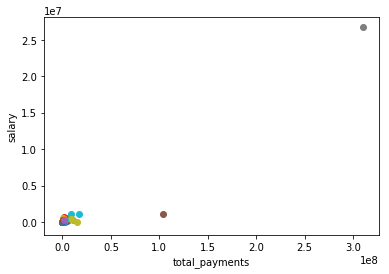

In [7]:
### Task 2: Remove outliers
### Visualize outliers
features = ['salary', 'total_payments']
data = featureFormat(data_dict,features)

for point in data:
    salary = point[0]
    total_payments = point[1]
    matplotlib.pyplot.scatter(total_payments, salary)

matplotlib.pyplot.xlabel("total_payments")
matplotlib.pyplot.ylabel("salary")
matplotlib.pyplot.show()

Those two big outliers (grey and black points) are caused by the Total and The Travel Agency in the Park lines. Let's remove them from our dataset and visualize again:

In [8]:
### Delete "Total" and "The Travel Agency in the Park" lines
data_dict.pop("TOTAL",0)
data_dict.pop("THE TRAVEL AGENCY IN THE PARK",0)

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 362096,
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 362096,
 'total_stock_value': 'NaN'}

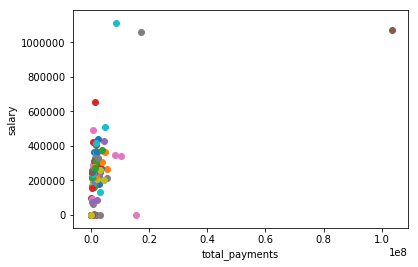

In [9]:
### Visualize new scatterplot with the those two outliers removed
data = featureFormat(data_dict,features)

for point in data:
    salary = point[0]
    total_payments = point[1]
    matplotlib.pyplot.scatter(total_payments, salary)

matplotlib.pyplot.xlabel("total_payments")
matplotlib.pyplot.ylabel("salary")
matplotlib.pyplot.show()

Now that we zoomed in on the actual data points, we see we still have a few outliers. Let's check if they are real outliers (= we should remove them as well) or useful in our analysis (= data points of real Enron employees having an exceptionally large salary).
- Brown data point: associated with total_payments > 100 millions and salary > 1 million: LAY, KENNETH L.
- Grey data point: total_payments ~ 20 millions and salary > 1 million: FREVERT, MARK A.
- Blue data point: total_payments ~ 10 millions and salary > 1 million: SKILLING, JEFFREY K.

Those outliers are valid data points, we'll keep them.

In [10]:
### Identify lines with no values:
for person in data_dict:
    if data_dict[person]["total_payments"] == "NaN":
        if data_dict[person]["total_stock_value"] == "NaN":
            print person, data_dict[person]["poi"], data_dict[person]['to_messages']

CHAN RONNIE False NaN
POWERS WILLIAM False 653
LOCKHART EUGENE E False NaN


Those three lines have a null or undefined total_payments and total_stock_value. All three of them are non-POI. However, one (William Powers) sent over 653 emails to a POI person, and the two others zero. 
Should we remove those data points?
If we keep them, it will teach our classifier that 'NaN' values are associated with non-POI. Is it a bad thing though? In those cases, the three are still Enron employees, and it is unlikely that they really did not get any salary; I'd argue the values are missing in our dataset, while others (related to emails) may not. I would not want my classifier to think that missing data on the salary side means that they are non-POIs. I'll remove those three lines as well:

In [11]:
# Delete null lines
data_dict.pop("CHAN RONNIE",0)
data_dict.pop("POWERS WILLIAM",0)
data_dict.pop("LOCKHART EUGENE E",0)

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 'NaN',
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 'NaN',
 'total_stock_value': 'NaN'}

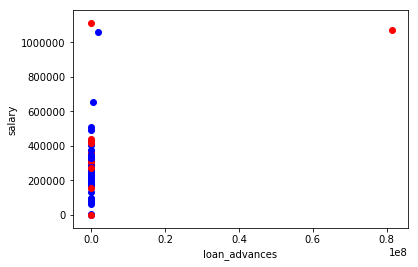

In [12]:
### Visualize salary vs loan advances
features = ['salary', 'loan_advances', 'poi']
data = featureFormat(data_dict,features)

for point in data:
    salary = point[0]
    loan_advances = point[1]
    mark_poi = point[2]
    if mark_poi:
        color = 'red'
    else:
        color = 'blue'
    matplotlib.pyplot.scatter(loan_advances, salary, color = color)

matplotlib.pyplot.xlabel("loan_advances")
matplotlib.pyplot.ylabel("salary")
matplotlib.pyplot.show()


The column "loan_advances" has only a handful of data points, making it a potential irrelevant feature; however, by far the biggest value for this field is 81.5 million under the name Kenneth Lay. I'd keep this feature as a potential POI identifier.

## Task 3 - Create New Feature(s) and Univariate Feature Selection

### Create new features:

Because we have less features related to the email dataset than the financial info in the Enron employees, I am going to create new features based on those emails variables: 
- fraction_to_poi = ratio of emails sent by this person to a POI / total emails sent by this person
- fraction_from_poi = ratio of emails sent from a POI to this person / total emails received by this person
- fraction_total_poi = ratio of emails sent involving POI (whether to or from) / total emails sent or received by this person

**Note:**
Creating new features using to/from POI emails can potentially raise validity questions: those to/from POI variables can only be built using the POI/non-POI identifiers, which can provoke some data leakage when we use the testing set.
However, for the rest of this section I am choosing to still use those variables to create new features, as it would still be interesting to see how the relationships and connections between Enron employees can impact their POI potentiality.

More on https://discussions.udacity.com/t/mistake-in-the-way-email-poi-features-are-engineered-in-the-course/4841/2

In [13]:
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = data_dict

import math
def computeFraction(ratio1, ratio2):
    if math.isnan(float(ratio1)) == True:
        fraction = 0.
    if math.isnan(float(ratio2)) == True:
        fraction = 0.
    if ratio2 == 0:
        fraction = 0.
    else:
        fraction = float(ratio1) / float(ratio2)
    return fraction

def addNumbers(add1, add2):
    if str(add1).lower() == 'nan' and str(add2).lower() == 'nan':
        add = 0.
    if str(add1).lower() == 'nan':
        add = float(add2)
    if str(add2).lower() == 'nan':
        add = float(add1)
    if math.isnan(float(add1)) == True and math.isnan(float(add2)) == True:
        add = 0.
    if math.isnan(float(add1)) == True:
        add = float(add2)
    if math.isnan(float(add2)) == True:
        add = float(add1)
    else:
        add = float(add1 + add2)
    return add

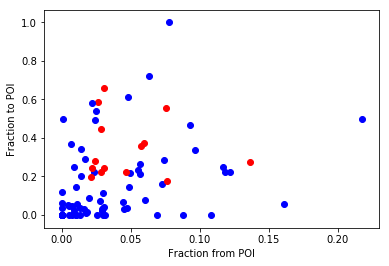

In [14]:
for person in my_dataset:
    mark_poi = my_dataset[person]["poi"]
    #all_messages = my_dataset[person]["from_messages"] + my_dataset[person]["to_messages"]
    #all_poi_messages = my_dataset[person]["from_this_person_to_poi"] + my_dataset[person]["from_poi_to_this_person"]
    all_messages1 = addNumbers(my_dataset[person]["from_messages"], my_dataset[person]["to_messages"])
    all_poi_messages1 = addNumbers(my_dataset[person]["from_this_person_to_poi"], my_dataset[person]["from_poi_to_this_person"])
    fraction_to_poi = computeFraction(my_dataset[person]["from_this_person_to_poi"], my_dataset[person]["from_messages"])
    fraction_from_poi = computeFraction(my_dataset[person]["from_poi_to_this_person"],my_dataset[person]["to_messages"])
    fraction_total_poi = computeFraction(all_poi_messages1, all_messages1)
    if mark_poi:
        color = 'red'
    else:
        color = 'blue'
    matplotlib.pyplot.scatter(fraction_from_poi, fraction_to_poi, color=color)
     
matplotlib.pyplot.xlabel("Fraction from POI")
matplotlib.pyplot.ylabel("Fraction to POI")
matplotlib.pyplot.show()

for name in my_dataset.iteritems():
    #all_messages = float(name[1]['to_messages']) + float(name[1]['from_messages'])
    #all_poi_messages = float(name[1]['from_this_person_to_poi']) + float(name[1]['from_poi_to_this_person'])
    all_messages2 = addNumbers(name[1]['to_messages'], name[1]['from_messages'])
    all_poi_messages2 = addNumbers(name[1]['from_this_person_to_poi'], name[1]['from_poi_to_this_person'])
    name[1]['fraction_to_poi'] = computeFraction(name[1]['from_this_person_to_poi'], name[1]['from_messages'])
    name[1]['fraction_from_poi'] = computeFraction(name[1]['from_poi_to_this_person'], name[1]['to_messages'])
    name[1]['fraction_total_poi'] = computeFraction(all_poi_messages2, all_messages2)

In [15]:
import math

for person in my_dataset:
    if math.isnan(my_dataset[person]['fraction_to_poi']) == True:
        my_dataset[person]['fraction_to_poi'] = 0.
    if math.isnan(my_dataset[person]['fraction_from_poi']) == True:
        my_dataset[person]['fraction_from_poi'] = 0.
    if math.isnan(my_dataset[person]['fraction_total_poi']) == True:
        my_dataset[person]['fraction_total_poi'] = 0.

Let's now evaluate how helpful those new features are in identifying POIs. To do this, we'll apply univariate feature selection to all our features, including the new ones, and rank them by feature importance score:

### Univariate feature selection

In [16]:
## Extract features and labels from dataset for local testing
features_list = poi_label + financial_features + email_features + ['fraction_to_poi'] + ['fraction_from_poi'] + ['fraction_total_poi']

data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

salary
4.33971279621
deferral_payments
0.204302456497
total_payments
2.39876190776
loan_advances
2.05681045231
bonus
4.84799807106
restricted_stock_deferred
0.0989839553933
deferred_income
2.98266064854
total_stock_value
5.50381457659
expenses
1.7646532732
exercised_stock_options
5.62629893236
other
1.34134574596
long_term_incentive
2.63289288988
restricted_stock
2.48316601388
director_fees
0.778269984842
to_messages
0.671085046022
from_poi_to_this_person
1.57956092627
from_messages
0.173009509987
from_this_person_to_poi
0.879272774071
shared_receipt_with_poi
2.33275443017
fraction_to_poi
3.97827831993
fraction_from_poi
1.05867622901
fraction_total_poi
1.60873442647


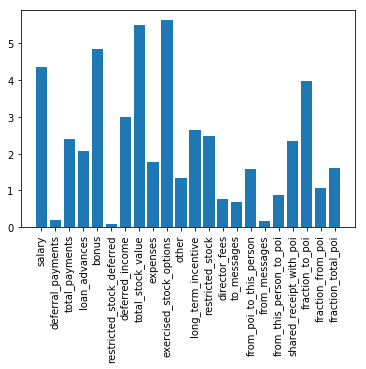

In [17]:
# Univariate feature selection: SelectKBest selects the K features that are most powerful (where K is a parameter).
# Perform feature selection
selector = SelectKBest(f_classif, k='all')
selector = selector.fit(features, labels)

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)
for s in range(len(features_list) - 1):
    print features_list[s+1]
    print scores[s]

# Print best features
#features_selected = [features_list[i+1] for i in selector.get_support(indices=True)]
#features_selected=selector.get_support()
#best_features = []
#for bool, feature in zip(features_selected, features_list):
    #if bool:
        #best_features.append(feature)
#print best_features

# Plot the scores.
plt.bar(range(len(features_list)-1), scores)
plt.xticks(range(len(features_list)-1), features_list[1:], rotation='vertical')
plt.show()

# Help:
# https://datascience.stackexchange.com/questions/10773/how-does-selectkbest-work
# https://stackoverflow.com/questions/39839112/the-easiest-way-for-getting-feature-names-after-running-selectkbest-in-scikit-le

We see here that our fraction_to_poi feature seems quite helpful in determining if a person is a POI compared to the other email features, such as fraction_from_poi or from_this_person_to_poi. Maybe this new feature will make the cut to our final list of features.

There are two possible ways to use those feature importance scores in our feature selection:
1. Previously, we selected k='all' in our selectKBest; we can now iterate over different values for k, with the value for k selected based on which value yielded the best precision/recall scores.
2. We can perform the feature selection here, by defining a cut-off point based on where the scores drop-off significantly. We then keep all features above that cut-off point.

Here, I'm choosing to apply the first option. While it is quite clear from the above scores that 5 features are much more important than the others in identifying POIs (salary, bonus, total stock value, exercised stock options and fraction to POI have scores in between 3.9 and 5.6, while the 6th important feature - deferred income - has a score right below 3), I'll try to reach that conclusion with my classifiers. 

I'll set up different values for k and iterate over my 4 chosen classifiers below (Naive Bayes, decision tree, random forest, AdaBoost) and for each value of k I'll put below which algorithm was more efficient and what were its accuracy, precision and recall scores. After locking an optimal k value and a classifier, I'll proceed to check my intuition using GridSearchCV to identify the best parameters for the chosen classifier (should match my conclusion using different values of k).

For k = 'all':
    1. best classifier: Naive Bayes
    2. accuracy: 0.93
    3. average F1: 0.94

for k = 10:
    1. best classifier: Naive Bayes
    2. accuracy: 0.896
    3. average F1: 0.89

for k = 6:
    1. best classifier: Naive Bayes
    2. accuracy: 0.92
    3. average F1: 0.92
    
for k = 5:
    1. best classifier: Naive Bayes
    2. accuracy: 0.92
    3. average F1: 0.92
    
for k = 4:
    1. best classifier: Naive Bayes & Decision tree
    2. accuracy: 0.92
    3. average F1: 0.92

for k = 3:
    1. best classifier: Naive Bayes & Decision tree
    2. accuracy: 0.909
    3. average F1: 0.91

## Task 4 - Try a Variety of Classifiers

In [18]:
# Univariate feature selection: SelectKBest selects the K features that are most powerful (where K is a parameter).
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

# Perform feature selection
selector = SelectKBest(k=6) # change k value
selector = selector.fit(features, labels)

features_selected = [features_list[i+1] for i in selector.get_support(indices=True)]
#features_selected=selector.get_support()
best_features = []
for bool, feature in zip(features_selected, features_list):
    if bool:
        best_features.append(feature)
print best_features

['poi', 'salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus']


In [19]:
data = featureFormat(my_dataset, best_features, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [20]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info: http://scikit-learn.org/stable/modules/pipeline.html

# Split into a training and testing set
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=42)

"""
hold out 25% of the data for testing and set the random_state parameter to 42 
(random_state controls which points go into the training set and which are used for testing; 
setting it to 42 means we know exactly which events are in which set, and can check the results you get).
"""

'\nhold out 25% of the data for testing and set the random_state parameter to 42 \n(random_state controls which points go into the training set and which are used for testing; \nsetting it to 42 means we know exactly which events are in which set, and can check the results you get).\n'

### Naive Bayes

In [21]:
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
clf = GaussianNB() #random_state = 42 put the same random state for every clf, to compare their performance on the same data

t0 = time()
clf.fit(features_train, labels_train)
print "training time:", round(time()-t0, 3), "s"

t0 = time()
pred = clf.predict(features_test)
print "prediction time:", round(time()-t0, 3), "s"
print "---------"

print "Accuracy score: ", accuracy_score(pred, labels_test)

#precision = precision_score(labels_test, pred)
#print "Precision: ", precision

#recall = recall_score(labels_test, pred)
#print "Recall: ", recall

# Calculate F1 score:
#f1 = 2 * (precision * recall) / (precision + recall)
#print "The F1 score is: ", f1

target_names = ["Not POI", "POI"]
classification = classification_report(y_true=labels_test, y_pred=pred, target_names=target_names)
print '\n Classification Report:'
print classification

training time: 0.032 s
prediction time: 0.002 s
---------
Accuracy score:  0.92

 Classification Report:
             precision    recall  f1-score   support

    Not POI       0.96      0.96      0.96        24
        POI       0.00      0.00      0.00         1

avg / total       0.92      0.92      0.92        25



As a reminder:
1. Precision = [true positives] / [true positives + false positives] <=> in 95% of the cases our model predicted that a person was not a POI, it was right.
2. Recall = [true positives] / [true positives + false negatives] <=> our model found 0% of the POI in our dataset.

This is an interesting result: it shows that our classifier has been underpredicting the number of POIs in the dataset; while it got almost all the proven non-POIs right; it also failed to identify several any POIs.

Taking a weighted average of precision and recall, we obtain a F1 score of 0.91 (the closer to 1 the F1 score gets, the better is our model at predicting if a person is a POI or not).


The precision and recall metrics are better peformance indicators than accuracy in our case, because of the class imbalance problem in our dataset. Class imbalance refers to the fact that we have very few POIs compared to the total number of employees in our dataset.

Because the goal of our model is to serve as a POI-identifier, we want to catch as many POIs as possible, even though the potential cost to this would be to mistakingly identify some non-POIs as POIs. Because of this, the usual accuracy metric is a poor performance indicator in the case of a class imbalance situation: to maximise accuracy, our model could very well never flag a POI person, as this occurs only 34 times out of 146, or in 23% of the cases.

Therefore, the performance metrics we will focus on for the remainder if this notebook are precision and recall (and therefore f1 score).

### Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state = 42)

t0 = time()
clf = clf.fit(features_train, labels_train)
print "training time:", round(time()-t0, 3), "s"

t0 = time()
pred = clf.predict(features_test)
print "prediction time:", round(time()-t0, 3), "s"
print "---------"

print "Accuracy score: ", accuracy_score(pred, labels_test)

#precision = precision_score(labels_test, pred)
#print "Precision: ", precision

#recall = recall_score(labels_test, pred)
#print "Recall: ", recall

# Calculate F1 score:
#f1 = 2 * (precision * recall) / (precision + recall)
#print "The F1 score is: ", f1

target_names = ["Not POI", "POI"]
classification = classification_report(y_true=labels_test, y_pred=pred, target_names=target_names)
print '\n Classification Report:'
print classification

training time: 0.083 s
prediction time: 0.014 s
---------
Accuracy score:  0.92

 Classification Report:
             precision    recall  f1-score   support

    Not POI       0.96      0.96      0.96        24
        POI       0.00      0.00      0.00         1

avg / total       0.92      0.92      0.92        25



### Decision Tree

In [23]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(random_state=42)

t0 = time()
clf = clf.fit(features_train, labels_train)
print "training time:", round(time()-t0, 3), "s"

t0 = time()
pred = clf.predict(features_test)
print "prediction time:", round(time()-t0, 3), "s"
print "---------"

print "Accuracy score: ", accuracy_score(pred, labels_test)

#precision = precision_score(labels_test, pred)
#print "Precision: ", precision

#recall = recall_score(labels_test, pred)
#print "Recall: ", recall

# Calculate F1 score:
#f1 = 2 * (precision * recall) / (precision + recall)
#print "The F1 score is: ", f1

target_names = ["Not POI", "POI"]
classification = classification_report(y_true=labels_test, y_pred=pred, target_names=target_names)
print '\n Classification Report:'
print classification

training time: 0.002 s
prediction time: 0.001 s
---------
Accuracy score:  0.8

 Classification Report:
             precision    recall  f1-score   support

    Not POI       0.95      0.83      0.89        24
        POI       0.00      0.00      0.00         1

avg / total       0.91      0.80      0.85        25



### AdaBoost

In [24]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(random_state=42) #algorithm='SAMME.R', base_estimator=None, learning_rate=1.0, n_estimators=50

t0 = time()
clf = clf.fit(features_train, labels_train)
print "training time:", round(time()-t0, 3), "s"

t0 = time()
pred = clf.predict(features_test)
print "prediction time:", round(time()-t0, 3), "s"
print "---------"

print "Accuracy score: ", accuracy_score(pred, labels_test)

#precision = precision_score(labels_test, pred)
#print "Precision: ", precision

#recall = recall_score(labels_test, pred)
#print "Recall: ", recall

# Calculate F1 score:
#f1 = 2 * (precision * recall) / (precision + recall)
#print "The F1 score is: ", f1

target_names = ["Not POI", "POI"]
classification = classification_report(y_true=labels_test, y_pred=pred, target_names=target_names)
print '\n Classification Report:'
print classification

training time: 0.281 s
prediction time: 0.01 s
---------
Accuracy score:  0.88

 Classification Report:
             precision    recall  f1-score   support

    Not POI       0.96      0.92      0.94        24
        POI       0.00      0.00      0.00         1

avg / total       0.92      0.88      0.90        25



In [25]:
#print clf.feature_importances_

important_features = []
for x,i in enumerate(clf.feature_importances_):
    if i>0.2:
        important_features.append([str(x),str(i)])
        #print (x,i)
    print important_features


[['0', '0.3']]
[['0', '0.3']]
[['0', '0.3'], ['2', '0.44']]
[['0', '0.3'], ['2', '0.44']]
[['0', '0.3'], ['2', '0.44']]


### Feature Scaling

The idea behind feature scaling, also called data normalization, is to make sure the parameters of our algorithms are on a similar scale. This is especially useful when parameters can take large ranges of values.

While Naive Bayes and tree algorithms perform feature scaling by design, other algorithms may require manual feature scaling by the user. This is the case of the classifiers calculating the distance between two points by the Euclidian distance, for instance K nearest neighbors: as KNN measures the distance between pairs of samples, if there is a big difference in the units used for the variables, some features will be more impactful than others in the measurement of that distance and will automatically be identified by the algorithm as the biggest drivers of that distance. Therefore, the range of all features should be normalized so that each feature contributes approximately proportionately to the final distance.

Another benefit of feature scaling is that gradient descent can be performed more quickly.

### Conclusion

From running our algorithms with different values for k, we can see that Naive Bayes and Decision tree seem to be equally good at predicting if a person is a POI. We do not need to apply feature scaling to those classifiers as it is already done by design.

Let's now apply parameter tuning to this, using GridSearchCV.

## Task 5 - Tune the Classifier

### Parameter Tuning

For the remainder of this document, I'll choose a decision tree as my classifier. Decision trees have several hyperparameters: criterion, max_features, max_depth, min_sample_split, etc. Depending on how they are set up, all of those parameters can greatly impact the quality of our model. In the previous section, they were all set to default; in this section, I am going to identify the optimal value for them using GridSearchCV.

**Notes on GridSearchCV from the forum:**
1. Accuracy is the default metric used by GridSearchCV, but isn't a particularly good one for this project. It's fairly easy to get high accuracy even if you're just predicting "non-poi" for everything. So I'd advise setting GridSearchCV's scoring argument to "f1", which will use the f1 score.
2. By default, GridSearchCV uses KFold to partition its various internal train-test splits. However, this isn't a great strategy for this project because of the small amount of data present. For instance, it's possible to end up with a split that has almost no pois using this type of cross validation, which could lead to incorrect best parameters. To solve this, I'd suggest using StratifiedShuffleSplit, which ensures that a good amount of pois and non-pois will end up in the data.
3. You should always test the default parameters with GridSearchCV, unless you know that they don't work. For instance, max_depth and max_features are None by default, so you should definitely try that value when testing in case it's better than all of the alternative values that you're testing.

https://discussions.udacity.com/t/working-on-final-project-gridsearchcv-suggested-parameters-leads-to-lesser-accuracy-precision-and-recall/245829/2

In [26]:
### Apply GridSearchCV using all the features available to have it issue the recommended number of features
features_list = poi_label + financial_features + email_features + ['fraction_to_poi'] + ['fraction_from_poi'] + ['fraction_total_poi']
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

print features_list

['poi', 'salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees', 'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi', 'fraction_to_poi', 'fraction_from_poi', 'fraction_total_poi']


In [27]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall using our testing script. 
###Check the tester.py script in the final project folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses stratified shuffle split cross validation. 
###For more info: http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=42)

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

folds = 10
sss = StratifiedShuffleSplit(folds, random_state = 42) #test_size = 0.2

#create a dictionary with all the parameters we want to search through
parameters={'criterion': ('gini', 'entropy'),'min_samples_split' : range(4,40,2),'max_depth': range(4,20,2), 
            'max_features': range(3,12,1)} #'random_state': range(2,100,2)
clf_tree = tree.DecisionTreeClassifier() #random_state = 42
gridsearch = GridSearchCV(clf_tree, param_grid = parameters, cv=sss, scoring="f1") 
gridsearch.fit(features_train, labels_train)

print "Best Score: {}".format(gridsearch.best_score_)
print "Best params: {}".format(gridsearch.best_params_)

C:\Users\Flo\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Best Score: 0.536666666667
Best params: {'max_features': 7, 'min_samples_split': 14, 'criterion': 'gini', 'max_depth': 12}


Above are listed the optimal parameters for our decision tree; let's apply them and re-run our algorithm to compare our new accuracy and f1 score to the ones obtained in Task 4.

### Validation

Finally, we can validate our model by deploying it on a testing dataset, to see how our model performs with unknown data points. This is what we've been doing all along in this notebook using train_test_split.

To adress the class imbalance problem (very low number of POIs compared to the total number of employees in our dataset), I will use cross validation with a stratified shuffle split for the validation process.

Cross-validation will solve the issue that we had earlier in this project, which is that our datapoints saved for testing with a train_test_split are lost for training, while we have very few POIs to train on to start with. K-fold cross-validation will partition the data into k bins of equal size, and run k separate learning experiments to then average the results, and this is also what is used in stratified shuffle split cross-validation.
StratifiedShuffleSplit will ensure that percentage of samples for each class are preserved throughout the experiments.

In [41]:
# Apply recommended number of features
selector = SelectKBest(k=7) # select k as the recommended number of features
selector = selector.fit(features_train, labels_train)

features_selected = [features_list[i+1] for i in selector.get_support(indices=True)]
#features_selected=selector.get_support()
best_features = []
for bool, feature in zip(features_selected, features_list):
    if bool:
        best_features.append(feature)
print best_features

data = featureFormat(my_dataset, best_features, sort_keys = True)

### split into labels and features (this line assumes that the first feature in the array is the label, 
###which is why "poi" must always be first in features_list
labels, features = targetFeatureSplit(data)

['poi', 'salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred']


In [42]:
print 'Decision Tree'
t0 = time()
clf = tree.DecisionTreeClassifier(criterion='gini', min_samples_split=14, max_depth=12) #random_state=80
clf.fit(features_train, labels_train)
print "Training time:", round(time()-t0, 3), "s"
t1 = time()
pred = clf.predict(features_test)
print "Predicting time:", round(time()-t1, 3), "s"

accuracy = clf.score(features_test, labels_test)
print "Accuracy:", accuracy

#from sklearn.metrics import precision_score
#precision = precision_score(labels_test, pred, average='binary')
#print "Precision Score:", precision

#from sklearn.metrics import recall_score
#recall = recall_score(labels_test, pred, average='binary')
#print "Recall Score:", recall

target_names = ["Not POI", "POI"]
classification = classification_report(y_true=labels_test, y_pred=pred, target_names=target_names)
print '\n Classification Report:'
print classification

Decision Tree
Training time: 0.003 s
Predicting time: 0.0 s
Accuracy: 0.896551724138

 Classification Report:
             precision    recall  f1-score   support

    Not POI       0.89      1.00      0.94        25
        POI       1.00      0.25      0.40         4

avg / total       0.91      0.90      0.87        29



Finally, we can use tester.py to test our model and verify that precision and recall are > 0.3:

## Task 6 - Export Files for Submission

In [44]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)

In [45]:
# %load tester.py
#!/usr/bin/pickle

""" a basic script for importing student's POI identifier,
    and checking the results that they get from it 
 
    requires that the algorithm, dataset, and features list
    be written to my_classifier.pkl, my_dataset.pkl, and
    my_feature_list.pkl, respectively

    that process should happen at the end of poi_id.py
"""

import pickle
import sys
from sklearn.cross_validation import StratifiedShuffleSplit
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit

PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
\tFalse negatives: {:4d}\tTrue negatives: {:4d}"

def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print clf
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predicitons."

CLF_PICKLE_FILENAME = "my_classifier.pkl"
DATASET_PICKLE_FILENAME = "my_dataset.pkl"
FEATURE_LIST_FILENAME = "my_feature_list.pkl"

def dump_classifier_and_data(clf, dataset, feature_list):
    with open(CLF_PICKLE_FILENAME, "w") as clf_outfile:
        pickle.dump(clf, clf_outfile)
    with open(DATASET_PICKLE_FILENAME, "w") as dataset_outfile:
        pickle.dump(dataset, dataset_outfile)
    with open(FEATURE_LIST_FILENAME, "w") as featurelist_outfile:
        pickle.dump(feature_list, featurelist_outfile)

def load_classifier_and_data():
    with open(CLF_PICKLE_FILENAME, "r") as clf_infile:
        clf = pickle.load(clf_infile)
    with open(DATASET_PICKLE_FILENAME, "r") as dataset_infile:
        dataset = pickle.load(dataset_infile)
    with open(FEATURE_LIST_FILENAME, "r") as featurelist_infile:
        feature_list = pickle.load(featurelist_infile)
    return clf, dataset, feature_list

def main():
    ### load up student's classifier, dataset, and feature_list
    clf, dataset, feature_list = load_classifier_and_data()
    ### Run testing script
    test_classifier(clf, dataset, feature_list)

if __name__ == '__main__':
    main()


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=12,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=14, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.82427	Precision: 0.32866	Recall: 0.30500	F1: 0.31639	F2: 0.30946
	Total predictions: 15000	True positives:  610	False positives: 1246	False negatives: 1390	True negatives: 11754

